### Import packages

In [1]:
import rioxarray as rxr
from pathlib import Path
import rioxarray as rxr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

### Define paths and aoi

In [2]:
# Define Scandinavian bounding box (AOI)
aoi_bounds = {
    "min_lon": 5.0,
    "max_lon": 32.0,
    "min_lat": 54.0,
    "max_lat": 72.0
}

In [3]:
# Define Bio-ORACLE folder structure
base = Path().resolve()
biooracle_dir = base / "Data" / "Bio_oracle"
raster_dir = biooracle_dir / "2000_2010" / "Mean_Cropped"

### Datapreperation

In [4]:
# Define time periods to process
mean_folders = ["2090_2100"]  # list of folders with decadal mean data

# Loop through each specified period folder
for period in mean_folders:  # iterate over each period
    input_folder = biooracle_dir / period / "Mean"  # define input folder path
    output_folder = biooracle_dir / period / "Mean_Cropped"  # define output folder path
    output_folder.mkdir(parents=True, exist_ok=True)  # create output folder if it doesn't exist

    print(f"\n Processing: {period}")  # log current period

    # Process each NetCDF file in the input folder
    for nc_file in input_folder.glob("*.nc"):  # loop through all .nc files
        try:
            # Load raster dataset and remove singleton dimensions
            ds = rxr.open_rasterio(nc_file, masked=True).squeeze()  # read and squeeze dimensions

            # Manually set CRS if missing
            if not ds.rio.crs:  # check if CRS is defined
                ds.rio.write_crs("EPSG:4326", inplace=True)  # assign WGS84 if missing

            # Clip raster to Scandinavian Area of Interest (AOI)
            ds_clipped = ds.rio.clip_box(
                minx=aoi_bounds["min_lon"],  # western boundary
                miny=aoi_bounds["min_lat"],  # southern boundary
                maxx=aoi_bounds["max_lon"],  # eastern boundary
                maxy=aoi_bounds["max_lat"]   # northern boundary
            )

            # Generate output file path using variable name
            var_name = nc_file.stem.split("_")[0]  # extract variable name from filename
            out_path = output_folder / f"{var_name}.tif"  # construct output path

            # Save the clipped raster to GeoTIFF
            ds_clipped.rio.to_raster(out_path)  # export raster
            print(f" Saved: {out_path.name}")  # confirm save

        except Exception as e:  # handle errors gracefully
            print(f" Failed to process {nc_file.name}: {e}")  # log failure



 Processing: 2090_2100
 Saved: chl.tif
 Saved: clt.tif
 Saved: dfe.tif
 Saved: mlotst.tif
 Saved: no3.tif
 Saved: o2.tif
 Saved: phyc.tif
 Saved: ph.tif
 Saved: po4.tif
 Saved: siconc.tif
 Saved: sithick.tif
 Saved: si.tif
 Saved: so.tif
 Saved: swd.tif
 Saved: sws.tif
 Saved: tas.tif
 Saved: thetao.tif


### Check prepared for redudant data

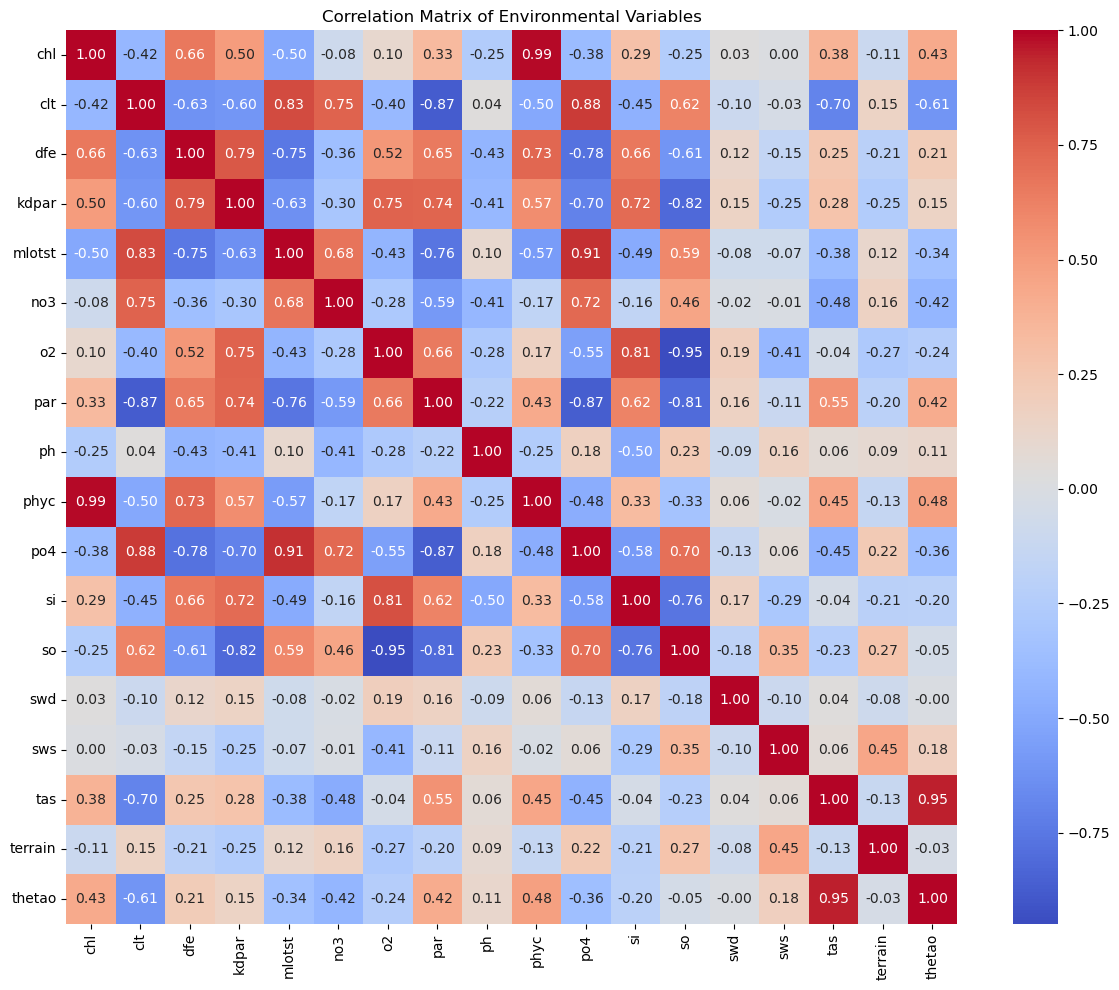


 VIF Summary with High Correlation Info (r ≥ 0.85):
   Variable     VIF Highly Correlated With
9      phyc  164.50                    chl
0       chl  128.73                   phyc
6        o2   99.18                     so
12       so   87.21                     o2
17   thetao   33.38                    tas
15      tas   24.80                 thetao
10      po4   20.53       clt, mlotst, par
1       clt   17.24               par, po4
7       par   12.30               clt, po4
2       dfe   10.83                      -
4    mlotst   10.80                    po4
5       no3    8.26                      -
11       si    7.79                      -
3     kdpar    5.83                      -
8        ph    3.59                      -
14      sws    1.71                      -
16  terrain    1.42                      -
13      swd    1.07                      -


In [5]:
# --- Load all GeoTIFFs from the specified directory ---
raster_files = list(raster_dir.glob("*.tif"))  # list all .tif files in the folder
data_arrays = []  # list to store raster arrays
names = []  # list to store variable names

for f in raster_files:  # loop through each file
    try:
        da = rxr.open_rasterio(f, masked=True).squeeze()  # open and squeeze raster
        data_arrays.append(da)  # store data array
        names.append(f.stem)  # store variable name (filename without extension)
    except Exception as e:
        print(f" Failed to load {f.name}: {e}")  # log any loading errors

# --- Stack raster layers into a DataFrame of pixel values ---
stacked = pd.DataFrame({
    name: da.values.flatten() for name, da in zip(names, data_arrays)  # flatten each raster
})
stacked = stacked.dropna()  # remove rows with any missing values

# --- Plot and display correlation matrix heatmap ---
plt.figure(figsize=(12, 10))  # set figure size
sns.heatmap(stacked.corr(), annot=True, cmap="coolwarm", fmt=".2f")  # draw heatmap
plt.title("Correlation Matrix of Environmental Variables")  # add title
plt.tight_layout()  # adjust layout
plt.show()  # display figure

# --- Save correlation matrix heatmap as PNG ---
plt.figure(figsize=(12, 10))  # recreate figure
sns.heatmap(stacked.corr(), annot=True, cmap="coolwarm", fmt=".2f")  # redraw heatmap
plt.title("Correlation Matrix of Environmental Variables")  # add title again
plt.tight_layout()  # adjust layout
plt.savefig("correlation_matrix.png", dpi=300)  # save to file
plt.close()  # close figure to free memory

# --- Calculate VIF (Variance Inflation Factor) for each variable ---
X = add_constant(stacked)  # add intercept for VIF calculation
vif_df = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]  # compute VIF
})

# --- Set correlation threshold for identifying multicollinearity ---
correlation_matrix = stacked.corr()  # calculate correlation matrix
high_corr_threshold = 0.85  # set threshold for high correlation

# --- Match VIF scores with highly correlated variables ---
vif_info = []  # list to store summary info

for i, row in vif_df.iterrows():  # iterate over VIF results
    var = row["Variable"]
    vif = row["VIF"]

    if var == "const":  # skip the constant term
        continue

    # Identify variables highly correlated with the current one
    correlated_vars = correlation_matrix[var][
        (correlation_matrix[var].abs() >= high_corr_threshold) & (correlation_matrix.index != var)
    ].index.tolist()

    vif_info.append({
        "Variable": var,
        "VIF": round(vif, 2),
        "Highly Correlated With": ", ".join(correlated_vars) if correlated_vars else "-"  # join names
    })

# --- Display VIF summary with high correlation context ---
vif_summary = pd.DataFrame(vif_info).sort_values(by="VIF", ascending=False)  # sort by VIF
print("\n VIF Summary with High Correlation Info (r ≥ 0.85):")  # label output
print(vif_summary)  # print summary table
